Epoch 1/100
342/342 [==============================] - 3s 4ms/step - loss: 0.5398 - val_loss: 0.2970
Epoch 2/100
342/342 [==============================] - 1s 3ms/step - loss: 0.1666 - val_loss: 0.1456
Epoch 3/100
342/342 [==============================] - 1s 3ms/step - loss: 0.0796 - val_loss: 0.0594
Epoch 4/100
342/342 [==============================] - 1s 2ms/step - loss: 0.0388 - val_loss: 0.0270
Epoch 5/100
342/342 [==============================] - 1s 3ms/step - loss: 0.0227 - val_loss: 0.0211
Epoch 6/100
342/342 [==============================] - 1s 3ms/step - loss: 0.0176 - val_loss: 0.0175
Epoch 7/100
342/342 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0138
Epoch 8/100
342/342 [==============================] - 1s 3ms/step - loss: 0.0113 - val_loss: 0.0116
Epoch 9/100
342/342 [==============================] - 1s 4ms/step - loss: 0.0092 - val_loss: 0.0105
Epoch 10/100
342/342 [==============================] - 1s 3ms/step - loss: 0.0077 - val_lo

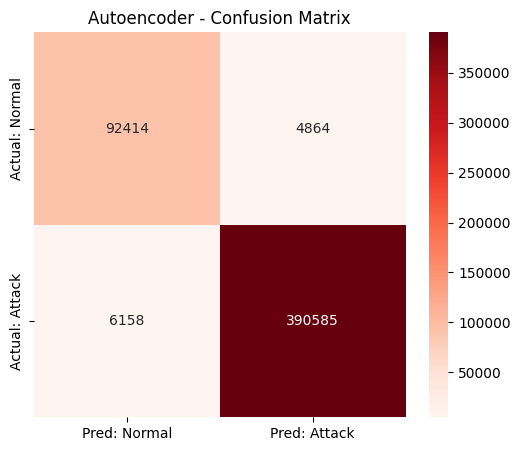

✅ Autoencoder model trained and saved. Threshold: 0.002354


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load preprocessed data
X_train = pd.read_csv("../data/processed/X_train_scaled.csv")
X_all = pd.read_csv("../data/processed/X_all_scaled.csv")
y_all = pd.read_csv("../data/processed/y_all.csv")

# Build Autoencoder model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

# Decoder
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Predict and compute reconstruction error
X_all_pred = autoencoder.predict(X_all)
reconstruction_error = np.mean(np.power(X_all - X_all_pred, 2), axis=1)

# Threshold from 95th percentile of normal data
threshold = np.percentile(reconstruction_error[y_all.values.flatten() == 0], 95)
y_pred = (reconstruction_error > threshold).astype(int)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_all, y_pred))

print("\nClassification Report:")
print(classification_report(y_all, y_pred))

print("\nROC-AUC Score:")
print(roc_auc_score(y_all, y_pred))

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_all, y_pred), annot=True, fmt='d', cmap='Reds',
            xticklabels=['Pred: Normal', 'Pred: Attack'],
            yticklabels=['Actual: Normal', 'Actual: Attack'])
plt.title("Autoencoder - Confusion Matrix")
plt.show()

# Save model and threshold
autoencoder.save("../models/autoencoder_model.h5")
joblib.dump(threshold, "../models/autoencoder_threshold.pkl")

print(f"✅ Autoencoder model trained and saved. Threshold: {threshold:.6f}")
